In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, MVNDiag, MVNFull, create_mog
from distributions import log_prob_banana, log_prob_cigar
from samplers import stams_mvn_hmc
from util import acf, ess
import matplotlib.pyplot as plt
import time
%matplotlib inline

Select the target distribution, family of q, and hyperparameter $\lambda_{KL}$

In [2]:
log_p = log_prob_banana
q_class = MVNIso
lambda_kl = 2.0
n_samples = 1000

Run the sampler

In [3]:
t_start = time.time()
info = stams_mvn_hmc(log_p, lambda_kl, q_class.new_random(d=2), n_samples=n_samples)
t_elapsed = time.time() - t_start

print(f"Got {n_samples} samples in {t_elapsed:.2f} seconds. Acceptance ratio = {info['accept']}")

Got 1000 samples in 38.92 seconds. Acceptance ratio = 0.8669999837875366


For visualization purposes, make a discrete grid of x, y and compute the $p(x)$ density on it

In [4]:
x = torch.linspace(-4, 4, 201)
xx, yy = torch.meshgrid(x, x)
xy = torch.stack([xx.flatten(), yy.flatten()], dim=0)
log_p_grid = log_p(xy)
p_grid = (log_p_grid - torch.logsumexp(log_p_grid.flatten(), dim=0)).exp().reshape(xx.size())

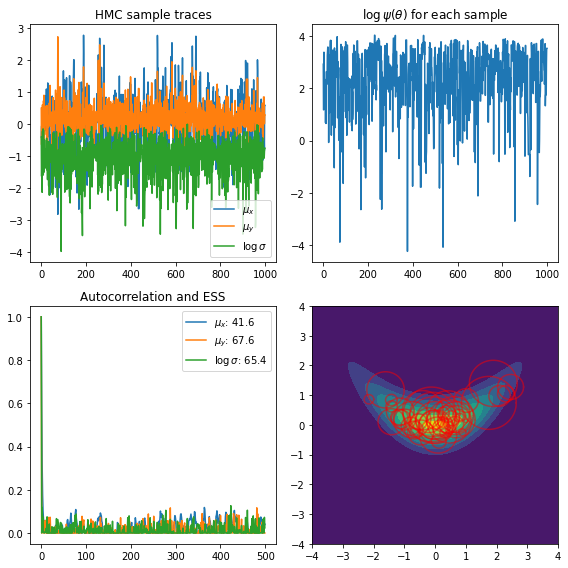

In [5]:
var_names = [r'$\mu_x$', r'$\mu_y$', r'$\log\sigma$']

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0,0].plot(info['samples'])
ax[0,0].legend(var_names)
ax[0,0].set_title('HMC sample traces')
ax[0,1].plot(info['log_psi'])
ax[0,1].set_title(r'$\log\psi(\theta)$ for each sample')
ax[1,0].plot(acf(info['samples']).clip(0.,1.))
ax[1,0].set_title('Autocorrelation and ESS')
ax[1,0].legend([f'{name}: {ess:.1f}' for name, ess in zip(var_names, ess(info['samples']))])
ax[1,1].contourf(xx, yy, p_grid, origin='lower')
q = q_class(d=2)
for i in range(0, n_samples, n_samples//50):
    q.theta = info['samples'][i, :]
    x, y = q.ellipse(nsigma=1.)
    ax[1,1].plot(x, y, '-', color=(1., 0., 0., .5))
fig.tight_layout()

Compute $m(x)$ and plot it alongside $p(x)$ contours

In [6]:
# Create the mixture using a torch.distributions.MixtureSameFamily, but clip the standard deviation of
# each kernel so that sigma >= grid spacing / 2. this prevents a few "delta" kernels from overwhelming
# the density
mixture = create_mog((q_class(theta=th).clip_stdev((x[1]-x[0])/2.) for th in info['samples']))
log_m_grid = mixture.log_prob(xy.T)
m_grid = (log_m_grid - torch.logsumexp(log_m_grid.flatten(), dim=0)).exp().reshape(xx.size())

Text(0.5, 1.0, 'm(x) with 1000 components, $\\lambda_{KL}=2.0$')

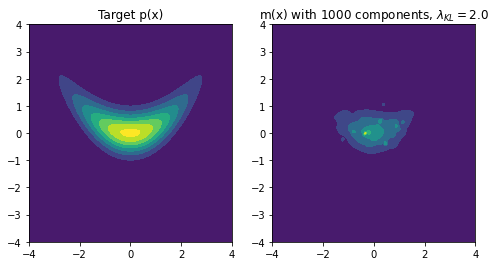

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].contourf(xx, yy, p_grid, origin='lower', vmin=0., vmax=p_grid.max())
ax[0].set_title('Target p(x)')
ax[1].contourf(xx, yy, m_grid, origin='lower', vmin=0.)
ax[1].set_title(f'm(x) with {n_samples} components, $\lambda_{{KL}}={lambda_kl}$')